Определите AUC_ROC и AUC_PR для модели логистической регрессии на тестовой выборке. Используйте реализацию модели в виде класса и функцию confusion, чтобы рассчитать TPR, FPR, precision, recal для различных порогов вероятности.


Дополнительное задание(не обязательно): Получите такие же характеристики для линейной регрессии и сравните две модели.

In [1]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from linear_regression import linear_regression
from scipy.stats import norm
%matplotlib inline

from sklearn import datasets
from matplotlib.colors import ListedColormap

In [2]:
class logistic_regression:
    def __init__(self, n_iterations=1000, eta=0.05):
        self.n_iterations=n_iterations
        self.eta=eta
    @staticmethod
    def log_grad(w, c, X, target):
        m = X.shape[0]
        y=(2*target-1)
        score=np.dot(X, w.T).flatten()
        Z=-y/(m*(1+np.exp(y*score)))
        grad=Z[np.newaxis, :].dot(X)
        return grad/m, np.sum(Z)/m
    @classmethod
    def optimize(cls, w, c, X, y, n_iterations, eta):
        for i in range(n_iterations):        
            grad_w, grad_c = cls.log_grad(w, c, X, y)
            w = w - eta * grad_w
            c = c - eta * grad_c
        return w, c
    def fit(self, X, y):
        w0 = np.zeros((1, X.shape[1]))
        c0=0
        self.w, self.c= self.optimize(w0, c0, X, y, self.n_iterations, self.eta)
    def predict_proba(self, X):  
        score=X.dot(self.w.T).flatten()+self.c
        return 1/(1+np.exp(-score))
    def predict(self, X, thr=0.5):
        proba=self.predict_proba(X)
        y_predicted = np.zeros(proba.shape, dtype=bool) 
        y_predicted[proba>thr]=1
        y_predicted[proba<=thr]=0
        return y_predicted

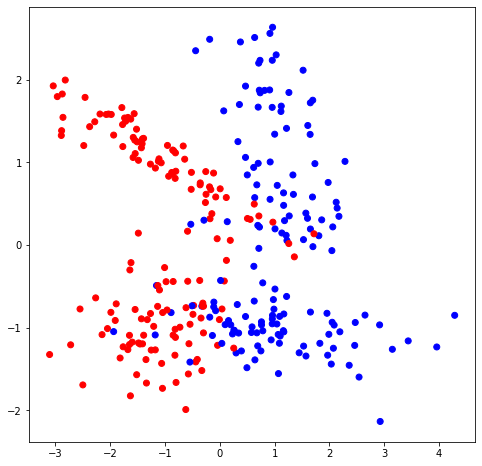

In [3]:
# сгеренируем данные с помощью sklearn.datasets
classes = datasets.make_classification(n_samples=300, n_features=2, n_informative=2,
                                       n_redundant=0, n_classes=2, random_state=1)
# datasets.make_blobs(centers = 2, cluster_std = 1.5, random_state=12)

# и изобразим их на графике
colors = ListedColormap(['red', 'blue'])

plt.figure(figsize=(8, 8))
plt.scatter([x[0] for x in classes[0]], [x[1] for x in classes[0]], c=classes[1], cmap=colors)

In [4]:
# перемешивание датасета
np.random.seed(12)
shuffle_index = np.random.permutation(classes[0].shape[0])
X_shuffled, y_shuffled = classes[0][shuffle_index], classes[1][shuffle_index]

# разбивка на обучающую и тестовую выборки
train_proportion = 0.7
train_test_cut = int(len(classes[0]) * train_proportion)

X_train, X_test, y_train, y_test = \
    X_shuffled[:train_test_cut], \
    X_shuffled[train_test_cut:], \
    y_shuffled[:train_test_cut], \
    y_shuffled[train_test_cut:]
    
print("Размер массива признаков обучающей выборки", X_train.shape)
print("Размер массива признаков тестовой выборки", X_test.shape)
print("Размер массива ответов для обучающей выборки", y_train.shape)
print("Размер массива ответов для тестовой выборки", y_test.shape)

Размер массива признаков обучающей выборки (210, 2)
Размер массива признаков тестовой выборки (90, 2)
Размер массива ответов для обучающей выборки (210,)
Размер массива ответов для тестовой выборки (90,)


In [5]:
mod=logistic_regression()
mod.fit(X_train, y_train)
y_predicted_test = mod.predict(X_test)
y_predicted_train = mod.predict(X_train)

# В качестве меры точности возьмем долю правильных ответов
train_accuracy = 100.0 - np.mean(np.abs(y_predicted_train - y_train)*100.0)
test_accuracy = 100.0 - np.mean(np.abs(y_predicted_test-y_test)*100.0)

print(f"Итоговый вектор весов w: {mod.w}")
print(f"Точность на обучающей выборке: {train_accuracy:.3f}")
print(f"Точность на тестовой выборке: {test_accuracy:.3f}")

Итоговый вектор весов w: [[0.11670043 0.00180514]]
Точность на обучающей выборке: 89.524
Точность на тестовой выборке: 88.889


In [6]:
def confusion(predicted, actual):
    TP=np.sum(np.logical_and(predicted==1, actual==1))
    FP=np.sum(np.logical_and(predicted==1, actual==0))
    FN=np.sum(np.logical_and(predicted==0, actual==1))
    TN=np.sum(np.logical_and(predicted==0, actual==0))
    return {'TP': TP, 'FP': FP, 'FN': FN, 'TN': TN}

In [7]:
print("Для порога по вероятности 0.25 на тестовой выборке имеем:"+
      f" {confusion(mod.predict(X_test, 0.25), y_test)}")
print("Для порога по вероятности 0.5 на тестовой выборке имеем:"+
      f" {confusion(mod.predict(X_test), y_test)}")
print("Для порога по вероятности 0.75 на тестовой выборке имеем:"+
      f" {confusion(mod.predict(X_test, 0.75), y_test)}")

Для порога по вероятности 0.25 на тестовой выборке имеем: {'TP': 47, 'FP': 43, 'FN': 0, 'TN': 0}
Для порога по вероятности 0.5 на тестовой выборке имеем: {'TP': 41, 'FP': 4, 'FN': 6, 'TN': 39}
Для порога по вероятности 0.75 на тестовой выборке имеем: {'TP': 0, 'FP': 0, 'FN': 47, 'TN': 43}


In [8]:
x=np.sort(np.random.uniform(0, 10, size=(50,)))
prob_x=norm.pdf(x, loc=3, scale=3.5)/(norm.pdf(x, loc=3, scale=3.5)+norm.pdf(x, loc=8, scale=1.5))
targets=(np.random.uniform(size=(50,))>prob_x).astype(int)
order=np.argsort(x)
x=x[order]
targets=targets[order]

In [11]:
for i in [i/10 for i in range(4,7)] :
    cofusion_fixed=confusion(mod.predict(X_test, i), y_test)
    sensitivity=cofusion_fixed['TP']/(cofusion_fixed['TP']+cofusion_fixed['FN'])
    specificity=cofusion_fixed['TN']/(cofusion_fixed['TN']+cofusion_fixed['FP'])

    precision=cofusion_fixed['TP']/(cofusion_fixed['TP']+cofusion_fixed['FP'])
    recall=sensitivity
    f1_score=2*precision*recall/(precision+recall)
    print(f"Для порога по вероятности {i} на тестовой выборке имеем: точность {precision:.3f},"+ 
          f"полноту {recall:.3f}, f1-скор {f1_score:.3f}")

Для порога по вероятности 0.4 на тестовой выборке имеем: точность 0.522,полноту 1.000, f1-скор 0.686
Для порога по вероятности 0.5 на тестовой выборке имеем: точность 0.911,полноту 0.872, f1-скор 0.891
Для порога по вероятности 0.6 на тестовой выборке имеем: точность 1.000,полноту 0.043, f1-скор 0.082


In [21]:
num_pos=np.sum(targets)
num_neg=len(targets)-num_pos
print(f'{num_pos} объектов положительного класса, {num_neg} объектов негативного класса')

15 объектов положительного класса, 35 объектов негативного класса


In [22]:
#Чувствительность
TPR=np.concatenate([[0], np.cumsum(1-targets)/num_neg])

#Ложно-позитивный уровень
FPR=np.concatenate([[0], np.cumsum(targets)/num_pos])

In [23]:
TPR

array([0.        , 0.02857143, 0.05714286, 0.08571429, 0.11428571,
       0.14285714, 0.17142857, 0.2       , 0.22857143, 0.25714286,
       0.28571429, 0.31428571, 0.34285714, 0.37142857, 0.4       ,
       0.42857143, 0.45714286, 0.48571429, 0.51428571, 0.54285714,
       0.57142857, 0.6       , 0.62857143, 0.65714286, 0.68571429,
       0.71428571, 0.74285714, 0.77142857, 0.8       , 0.82857143,
       0.85714286, 0.88571429, 0.91428571, 0.94285714, 0.97142857,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        ])

In [24]:
FPR

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.06666667, 0.13333333, 0.2       , 0.26666667,
       0.33333333, 0.4       , 0.46666667, 0.53333333, 0.6       ,
       0.66666667, 0.73333333, 0.8       , 0.86666667, 0.93333333,
       1.        ])

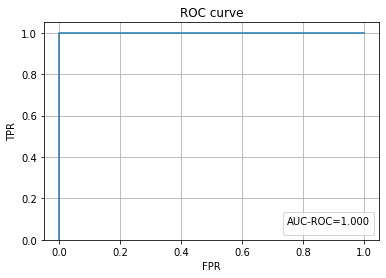

In [28]:
from numpy import trapz  # используем эту функцию для расчета площади под кривой

AUC_ROC = trapz(TPR, x = FPR, dx=0.1)

plt.title('ROC curve')
plt.ylim(0, 1.05)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.grid()
plt.legend(' ', title=f'AUC-ROC={AUC_ROC:.3f}', loc='lower right')
plt.plot(FPR, TPR)

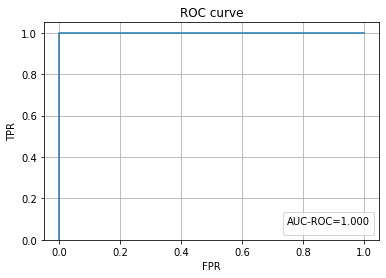

In [31]:
AUC_ROC = np.sum(0.5*(FPR[1:]-FPR[:-1])*(TPR[1:]+TPR[:-1]))

plt.title('ROC curve')
plt.ylim(0, 1.05)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.grid()
plt.legend(' ', title=f'AUC-ROC={AUC_ROC:.3f}', loc='lower right')
plt.plot(FPR, TPR)

In [32]:
precision=np.cumsum(1-targets)/(np.cumsum(1-targets)+np.cumsum(targets))
precision

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       0.97222222, 0.94594595, 0.92105263, 0.8974359 , 0.875     ,
       0.85365854, 0.83333333, 0.81395349, 0.79545455, 0.77777778,
       0.76086957, 0.74468085, 0.72916667, 0.71428571, 0.7       ])

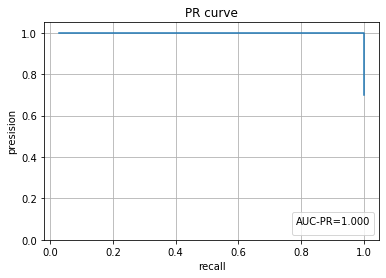

In [33]:
recall = TPR
AUC_PR = np.sum(precision*(TPR[1:]-TPR[:-1]))

plt.title('PR curve')
plt.ylim(0, 1.05)
plt.xlabel('recall')
plt.ylabel('presision')
plt.grid()
plt.legend(' ', title=f'AUC-PR={AUC_PR:.3f}', loc='lower right')
plt.plot(recall[1:], precision)